Expert adsorption energies
======================================================


One of the most common tasks in computational catalysis is calculating the binding energies or adsorption energies of small molecules on catalyst surfaces.

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

In [1]:
from __future__ import annotations

import os
import pickle
import time
from glob import glob

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ase.optimize import QuasiNewton
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.utils import DetectTrajAnomaly
from scipy.stats import linregress

# Set random seed to ensure adsorbate enumeration yields a valid candidate
# If using a larger number of random samples this wouldn't be necessary
np.random.seed(22)

# Introduction

We will reproduce Fig 6b from the following paper: Zhou, Jing, et al. "Enhanced Catalytic Activity of Bimetallic Ordered Catalysts for Nitrogen Reduction Reaction by Perturbation of Scaling Relations." ACS Catalysis 134 (2023): 2190-2201 (https://doi.org/10.1021/acscatal.2c05877).

The gist of this figure is a correlation between H* and NNH* adsorbates across many different alloy surfaces. Then, they identify a dividing line between these that separates surfaces known for HER and those known for NRR.

To do this, we will enumerate adsorbate-slab configurations and run ML relaxations on them to find the lowest energy configuration. We will assess parity between the model predicted values and those reported in the paper. Finally we will make the figure and assess separability of the NRR favored and HER favored domains.

# Enumerate the adsorbate-slab configurations to run relaxations on

Be sure to set the path in `fairchem/data/oc/configs/paths.py` to point to the correct place or pass the paths as an argument. The database pickles can be found in `fairchem/data/oc/databases/pkls` (some pkl files are only downloaded by running the command `python src/fairchem/core/scripts/download_large_files.py oc` from the root of the fairchem repo). We will show one explicitly here as an example and then run all of them in an automated fashion for brevity.

In [2]:
from pathlib import Path

import fairchem.data.oc

db = Path(fairchem.data.oc.__file__).parent / Path("databases/pkls/adsorbates.pkl")
db

PosixPath('/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/data/oc/databases/pkls/adsorbates.pkl')

## Work out a single example

We load one bulk id, create a bulk reference structure from it, then generate the surfaces we want to compute.

In [3]:
bulk_src_id = "oqmd-343039"
adsorbate_smiles_nnh = "*N*NH"
adsorbate_smiles_h = "*H"

bulk = Bulk(bulk_src_id_from_db=bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
adsorbate_H = Adsorbate(
    adsorbate_smiles_from_db=adsorbate_smiles_h, adsorbate_db_path=db
)
adsorbate_NNH = Adsorbate(
    adsorbate_smiles_from_db=adsorbate_smiles_nnh, adsorbate_db_path=db
)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(1, 1, 1))
slab

[Slab: (Ag36Pd12, (1, 1, 1), 0.16666666666666669, True)]

We now need to generate potential placements. We use two kinds of guesses, a heuristic and a random approach. This cell generates 13 potential adsorption geometries.

In [4]:
# Perform heuristic placements
heuristic_adslabs = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")

# Perform random placements
# (for AdsorbML we use `num_sites = 100` but we will use 4 for brevity here)
random_adslabs = AdsorbateSlabConfig(
    slab[0], adsorbate_H, mode="random_site_heuristic_placement", num_sites=4
)

adslabs = [*heuristic_adslabs.atoms_list, *random_adslabs.atoms_list]
len(adslabs)

13

Let's see what we are looking at. It is a little tricky to see the tiny H atom in these figures, but with some inspection you can see there are ontop, bridge, and hollow sites in different places. This is not an exhaustive search; you can increase the number of random placements to check more possibilities. The main idea here is to *increase* the probability you find the most relevant sites.

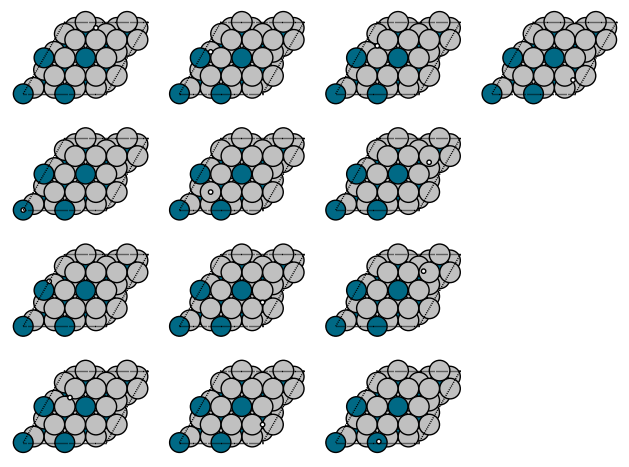

In [5]:
from ase.visualize.plot import plot_atoms

fig, axs = plt.subplots(4, 4)

for i, slab in enumerate(adslabs):
    plot_atoms(slab, axs[i % 4, i // 4])
    axs[i % 4, i // 4].set_axis_off()

for i in range(16):
    axs[i % 4, i // 4].set_axis_off()

plt.tight_layout()

### Run an ML relaxation

We will use an ASE compatible calculator to run these.

Running the model with QuasiNewton prints at each relaxation step which is a lot to print. So we will just run one to demonstrate what happens on each iteration.

In [6]:
os.makedirs(f"data/{bulk_src_id}_{adsorbate_smiles_h}", exist_ok=True)

# Define the
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

Now we setup and run the relaxation.

In [7]:
t0 = time.time()
os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
adslab = adslabs[0]
adslab.calc = calc
adslab.pbc = True
opt = QuasiNewton(adslab, trajectory=f"data/{bulk_src_id}_H/test.traj")
opt.run(fmax=0.05, steps=100)

print(f"Elapsed time {time.time() - t0:1.1f} seconds")

                Step[ FC]     Time          Energy          fmax
BFGSLineSearch:    0[  0] 00:59:20     -130.560599       0.7414
BFGSLineSearch:    1[  2] 00:59:20     -130.703194       0.3842


BFGSLineSearch:    2[  3] 00:59:20     -130.719020       0.1281
BFGSLineSearch:    3[  4] 00:59:20     -130.726698       0.1073


BFGSLineSearch:    4[  6] 00:59:20     -130.730347       0.0597
BFGSLineSearch:    5[  8] 00:59:20     -130.733393       0.0478
Elapsed time 1.3 seconds


With a GPU this runs pretty quickly. It is much slower on a CPU.

# Run all the systems

In principle you can run all the systems now. It takes about an hour though, and we leave that for a later exercise if you want. For now we will run the first two, and for later analysis we provide a results file of all the runs. Let's read in our reference file and take a look at what is in it.

In [8]:
with open("NRR_example_bulks.pkl", "rb") as f:
    bulks = pickle.load(f)

bulks

[{'atoms': Atoms(symbols='CuPd3', pbc=True, cell=[3.91276645, 3.91276645, 3.91276645], calculator=SinglePointDFTCalculator(...)),
  'src_id': 'oqmd-349719'},
 {'atoms': Atoms(symbols='Pd3Ag', pbc=True, cell=[4.02885979, 4.02885979, 4.02885979], calculator=SinglePointDFTCalculator(...)),
  'src_id': 'oqmd-345911'},
 {'atoms': Atoms(symbols='ScPd3', pbc=True, cell=[4.04684963, 4.04684963, 4.04684963], initial_charges=..., initial_magmoms=..., momenta=..., tags=..., calculator=SinglePointCalculator(...)),
  'src_id': 'mp-2677'},
 {'atoms': Atoms(symbols='Mo3Pd', pbc=True, cell=[3.96898192, 3.96898192, 3.96898192], initial_charges=..., initial_magmoms=..., momenta=..., tags=..., calculator=SinglePointCalculator(...)),
  'src_id': 'mp-1186014'},
 {'atoms': Atoms(symbols='Ag3Pd', pbc=True, cell=[4.14093081, 4.14093081, 4.14093081], calculator=SinglePointCalculator(...)),
  'src_id': 'oqmd-343039'},
 {'src_id': 'oqmd-348629',
  'atoms': Atoms(symbols='Ag3Cu', pbc=True, cell=[4.09439099, 4.094

We have 19 bulk materials we will consider. Next we extract the `src-id` for each one.

In [9]:
bulk_ids = [row["src_id"] for row in bulks]

In theory you would run all of these, but it takes about an hour with a GPU. We provide the relaxation logs and trajectories in the repo for the next step.

These steps are embarrassingly parallel, and can be launched that way to speed things up. The only thing you need to watch is that you don't exceed the available RAM, which will cause the Jupyter kernel to crash.

The goal here is to relax each candidate adsorption geometry and save the results in a trajectory file we will analyze later. Each trajectory file will have the geometry and final energy of the relaxed structure.

It is somewhat time consuming to run this. We're going to use a small number of bulks for the testing of this documentation, but otherwise run all of the results for the actual documentation.

In [10]:
import os

fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    num_bulks = 1
    num_sites = 5
    relaxation_steps = 20
else:
    num_bulks = -1
    num_sites = 20
    relaxation_steps = 300

In [11]:
import random
import time

from tqdm import tqdm

tinit = time.time()

random.seed(42)
random.shuffle(bulk_ids)

# Note we're just doing the first bulk_id!
for bulk_src_id in tqdm(bulk_ids[:num_bulks]):

    # Set up data directories
    os.makedirs("data/slabs/", exist_ok=True)
    os.makedirs(f"data/adslabs/{bulk_src_id}_H", exist_ok=True)
    os.makedirs(f"data/adslabs/{bulk_src_id}_NNH", exist_ok=True)

    # Enumerate slabs and establish adsorbates
    bulk = Bulk(bulk_src_id_from_db=bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
    slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(1, 1, 1))

    slab_atoms = slab[0].atoms.copy()
    slab_atoms.calc = calc
    slab_atoms.pbc = True
    opt = QuasiNewton(
        slab_atoms,
        trajectory=f"data/slabs/{bulk_src_id}.traj",
        logfile=f"data/slabs/{bulk_src_id}.log",
    )
    opt.run(fmax=0.05, steps=relaxation_steps)
    print(
        f"  Elapsed time: {time.time() - t0:1.1f} seconds for data/slabs/{bulk_src_id} slab relaxation"
    )

    # Perform heuristic placements
    heuristic_adslabs_H = AdsorbateSlabConfig(
        slab[0],
        adsorbate_H,
        mode="random_site_heuristic_placement",
        num_sites=num_sites,
    )
    heuristic_adslabs_NNH = AdsorbateSlabConfig(
        slab[0],
        adsorbate_NNH,
        mode="random_site_heuristic_placement",
        num_sites=num_sites,
    )

    print(f"{len(heuristic_adslabs_H.atoms_list)} H slabs to compute for {bulk_src_id}")
    print(
        f"{len(heuristic_adslabs_NNH.atoms_list)} NNH slabs to compute for {bulk_src_id}"
    )

    for idx, adslab in enumerate(heuristic_adslabs_H.atoms_list):
        t0 = time.time()
        adslab.calc = calc
        adslab.pbc = True
        print(f"Running data/adslabs/{bulk_src_id}_H/{idx}")
        opt = QuasiNewton(
            adslab,
            trajectory=f"data/adslabs/{bulk_src_id}_H/{idx}.traj",
            logfile=f"data/adslabs/{bulk_src_id}_H/{idx}.log",
        )
        opt.run(fmax=0.05, steps=200)
        print(
            f"  Elapsed time: {time.time() - t0:1.1f} seconds for data/adslabs/{bulk_src_id}_H/{idx}"
        )

    for idx, adslab in enumerate(heuristic_adslabs_NNH.atoms_list):
        t0 = time.time()
        adslab.calc = calc
        adslab.pbc = True
        print(f"Running data/adslabs/{bulk_src_id}_NNH/{idx}")
        opt = QuasiNewton(
            adslab,
            trajectory=f"data/adslabs/{bulk_src_id}_NNH/{idx}.traj",
            logfile=f"data/adslabs/{bulk_src_id}_NNH/{idx}.log",
        )
        opt.run(fmax=0.05, steps=relaxation_steps)
        print(
            f"  Elapsed time: {time.time() - t0:1.1f} seconds for data/adslabs/{bulk_src_id}_NNH/{idx}"
        )

print(f"Elapsed time: {time.time() - tinit:1.1f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

  Elapsed time: 2.3 seconds for data/slabs/oqmd-349496 slab relaxation
5 H slabs to compute for oqmd-349496
5 NNH slabs to compute for oqmd-349496
Running data/adslabs/oqmd-349496_H/0


  Elapsed time: 3.3 seconds for data/adslabs/oqmd-349496_H/0
Running data/adslabs/oqmd-349496_H/1


  Elapsed time: 2.5 seconds for data/adslabs/oqmd-349496_H/1
Running data/adslabs/oqmd-349496_H/2


  Elapsed time: 2.9 seconds for data/adslabs/oqmd-349496_H/2
Running data/adslabs/oqmd-349496_H/3


  Elapsed time: 2.8 seconds for data/adslabs/oqmd-349496_H/3
Running data/adslabs/oqmd-349496_H/4


  Elapsed time: 4.3 seconds for data/adslabs/oqmd-349496_H/4
Running data/adslabs/oqmd-349496_NNH/0


  Elapsed time: 4.6 seconds for data/adslabs/oqmd-349496_NNH/0
Running data/adslabs/oqmd-349496_NNH/1


  Elapsed time: 3.8 seconds for data/adslabs/oqmd-349496_NNH/1
Running data/adslabs/oqmd-349496_NNH/2


  Elapsed time: 5.1 seconds for data/adslabs/oqmd-349496_NNH/2
Running data/adslabs/oqmd-349496_NNH/3


  Elapsed time: 4.4 seconds for data/adslabs/oqmd-349496_NNH/3
Running data/adslabs/oqmd-349496_NNH/4


100%|██████████| 1/1 [00:39<00:00, 39.07s/it]

100%|██████████| 1/1 [00:39<00:00, 39.07s/it]

  Elapsed time: 4.5 seconds for data/adslabs/oqmd-349496_NNH/4
Elapsed time: 39.1 seconds


# Parse the trajectories and post-process

As a post-processing step we check to see if:

1. the adsorbate desorbed
2. the adsorbate disassociated
3. the adsorbate intercalated
4. the surface has changed

We check these because they affect our referencing scheme and may result in energies that don't mean what we think, e.g. they aren't just adsorption, but include contributions from other things like desorption, dissociation or reconstruction. For (4), the relaxed surface should really be supplied as well. It will be necessary when correcting the SP / RX energies later. Since we don't have it here, we will ommit supplying it, and the detector will instead compare the initial and final slab from the adsorbate-slab relaxation trajectory. If a relaxed slab is provided, the detector will compare it and the slab after the adsorbate-slab relaxation. The latter is more correct!

To compute the adsorption energies using the total energy UMA-OC20 model, we'll need the gas-phase reference energies from OC20 (see the original paper!). You could also calculate these quickly in DFT using a linear combination of H2O, H2, N2, and CO.

In [12]:
# reference energies from a linear combination of H2O/N2/CO/H2!
atomic_reference_energies = {
    "H": -3.477,
    "N": -8.083,
    "O": -7.204,
    "C": -7.282,
}

In this loop we find the most stable (most negative) adsorption energy for each adsorbate on each surface and save them in a DataFrame.

In [13]:
# Iterate over trajs to extract results
min_E = []
for file_outer in glob("data/adslabs/*"):
    ads = file_outer.split("_")[1]
    bulk = file_outer.split("/")[-1].split("_")[0]

    slab = ase.io.read(f"data/slabs/{bulk}.traj")
    results = []
    for file in glob(f"{file_outer}/*.traj"):
        rx_id = file.split("/")[-1].split(".")[0]
        traj = ase.io.read(file, ":")

        # Check to see if the trajectory is anomolous
        detector = DetectTrajAnomaly(traj[0], traj[-1], traj[0].get_tags())
        anom = (
            detector.is_adsorbate_dissociated()
            or detector.is_adsorbate_desorbed()
            or detector.has_surface_changed()
            or detector.is_adsorbate_intercalated()
        )
        rx_energy = (
            traj[-1].get_potential_energy()
            - slab.get_potential_energy()
            - sum(
                [
                    atomic_reference_energies[x]
                    for x in traj[0][traj[0].get_tags() == 2].get_chemical_symbols()
                ]
            )
        )

        results.append(
            {
                "relaxation_idx": rx_id,
                "relaxed_atoms": traj[-1],
                "relaxed_energy_ml": rx_energy,
                "anomolous": anom,
            }
        )
    df = pd.DataFrame(results)

    df = df[~df.anomolous].copy().reset_index()
    min_e = min(df.relaxed_energy_ml.tolist())
    min_E.append({"adsorbate": ads, "bulk_id": bulk, "min_E_ml": min_e})

df = pd.DataFrame(min_E)
df_h = df[df.adsorbate == "H"]
df_nnh = df[df.adsorbate == "NNH"]
df_flat = df_h.merge(df_nnh, on="bulk_id")

# Make parity plots for values obtained by ML v. reported in the paper

In [14]:
# Add literature data to the dataframe
with open("literature_data.pkl", "rb") as f:
    literature_data = pickle.load(f)
df_all = df_flat.merge(pd.DataFrame(literature_data), on="bulk_id")

/tmp/ipykernel_5832/1759892815.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  slope, intercept, r, p, se = linregress(x, y)
/tmp/ipykernel_5832/1759892815.py:37: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  slope, intercept, r, p, se = linregress(x, y)


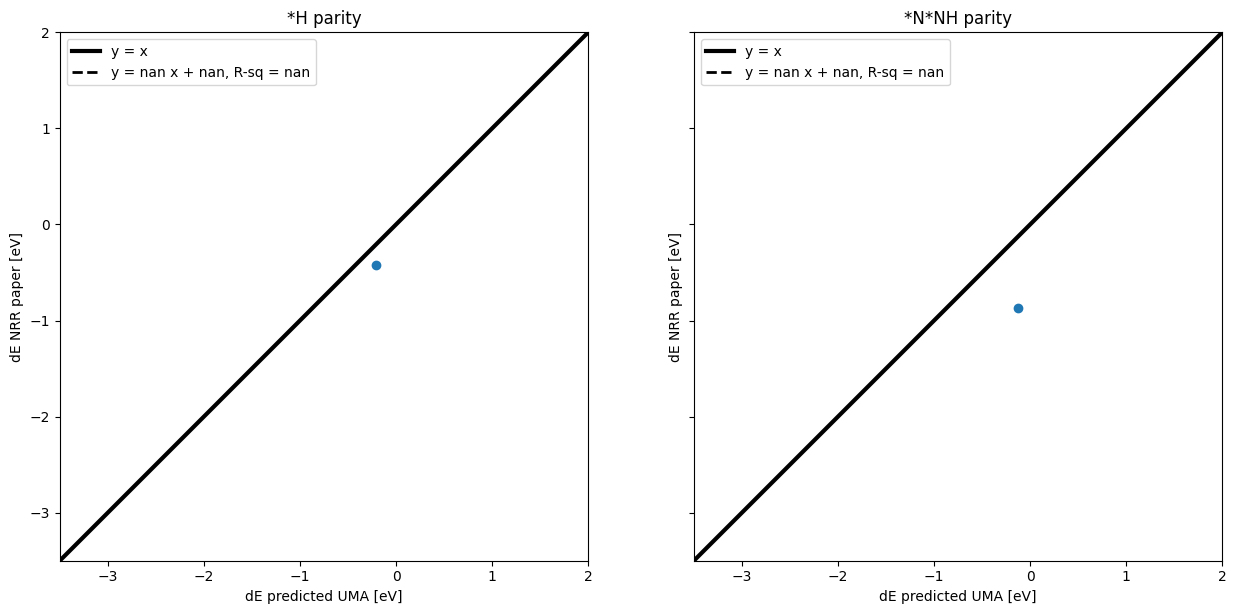

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(15)
x = df_all.min_E_ml_x.tolist()
y = df_all.E_lit_H.tolist()
ax1.set_title("*H parity")
ax1.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax1.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax1.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax1.scatter(x, y)
ax1.axis("square")
ax1.set_xlim([-3.5, 2])
ax1.set_ylim([-3.5, 2])
ax1.set_xlabel("dE predicted UMA [eV]")
ax1.set_ylabel("dE NRR paper [eV]")


x = df_all.min_E_ml_y.tolist()
y = df_all.E_lit_NNH.tolist()
ax2.set_title("*N*NH parity")
ax2.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax2.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax2.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax2.scatter(x, y)
ax2.axis("square")
ax2.set_xlim([-3.5, 2])
ax2.set_ylim([-3.5, 2])
ax2.set_xlabel("dE predicted UMA [eV]")
ax2.set_ylabel("dE NRR paper [eV]")
f.set_figwidth(15)
f.set_figheight(7)

# Make figure 6b and compare to literature results

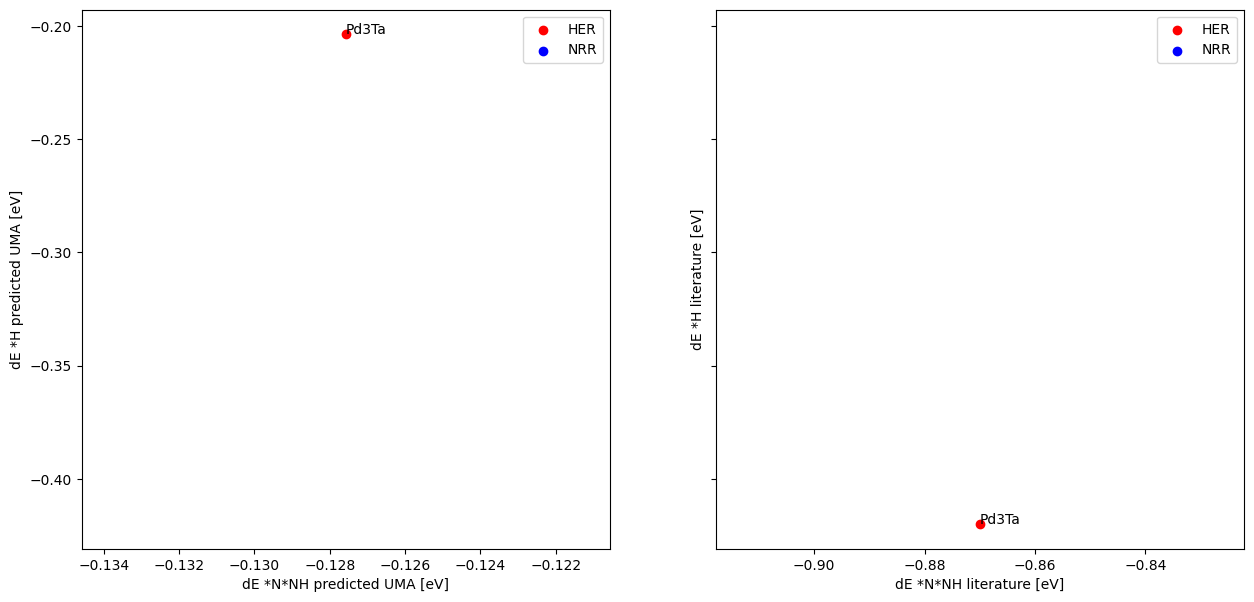

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x = df_all[df_all.reaction == "HER"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "HER"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax1.scatter(x, y, c="r", label="HER")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "NRR"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax1.scatter(x, y, c="b", label="NRR")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))


ax1.legend()
ax1.set_xlabel("dE *N*NH predicted UMA [eV]")
ax1.set_ylabel("dE *H predicted UMA [eV]")


x = df_all[df_all.reaction == "HER"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "HER"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax2.scatter(x, y, c="r", label="HER")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "NRR"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax2.scatter(x, y, c="b", label="NRR")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

ax2.legend()
ax2.set_xlabel("dE *N*NH literature [eV]")
ax2.set_ylabel("dE *H literature [eV]")
f.set_figwidth(15)
f.set_figheight(7)